This script contains:
- MR with 3 saccadic features and 'answer', 'Export_End_Trial_Time_ms'
- Lasso and Ridge with the five features
- SVR with the five features
- Subject wise error vs TOEIC score for each of the fitted models

Note: The codes could be easily modularized. I have kept it in a script form for ease of control.

In [21]:
library(ggplot2)
library(repr)
library(leaps)
library(glmnet)
library(e1071)
default_opt <- options()

In [22]:
df_toeic <- read.csv(file = '../fujiyoshi-data/rawdata.csv', header = TRUE, stringsAsFactors = FALSE)
col_names <- c('answer', 'TOEIC', 'subject', 'Export_End_Trial_Time_ms', 
               'Participant', 'Fixation_Count',
               'Fixation_Frequency_count_s', 'Fixation_Duration_Total_ms', 
               'Fixation_Duration_Average_ms', 'Fixation_Duration_Maximum_ms', 
               'Fixation_Duration_Minimum_ms', 'Fixation_Dispersion_Total_px', 
               'Fixation_Dispersion_Average_px', 'Fixation_Dispersion_Maximum_px', 
               'Fixation_Dispersion_Minimum_px', 'Saccade_Count', 
               'Saccade_Frequency_count_s', 'Saccade_Duration_Total_ms', 
               'Saccade_Duration_Average_ms', 'Saccade_Duration_Maximum_ms', 
               'Saccade_Duration_Minimum_ms', 'Saccade_Amplitude_Total_deg', 
               'Saccade_Amplitude_Average_deg', 'Saccade_Amplitude_Maximum_deg', 
               'Saccade_Amplitude_Minimum_deg', 'Saccade_Velocity_Total_deg_s', 
               'Saccade_Velocity_Average_deg_s', 'Saccade_Velocity_Maximum_deg_s', 
               'Saccade_Velocity_Minimum_deg_s', 'Saccade_Latency_Average_ms', 
               'Blink_Count', 'Blink_Frequency_count_s', 'Blink_Duration_Total_ms', 
               'Blink_Duration_Average_ms', 'Blink_Duration_Maximum_ms', 
               'Blink_Duration_Minimum_ms', 'Scanpath_Length_px')
colnames(df_toeic) <- col_names
df_toeic <- df_toeic[1:(nrow(df_toeic) - 2), ]
df_toeic$TOEIC <- as.numeric(df_toeic$TOEIC)
str(df_toeic)

'data.frame':	240 obs. of  37 variables:
 $ answer                        : num  1 2 3 1 3 1 1 3 2 1 ...
 $ TOEIC                         : num  600 600 600 600 600 600 600 600 600 600 ...
 $ subject                       : chr  "hoshika" "hoshika" "hoshika" "hoshika" ...
 $ Export_End_Trial_Time_ms      : num  542801 395178 266221 460026 568056 ...
 $ Participant                   : chr  "document1" "document2" "document3" "document5" ...
 $ Fixation_Count                : num  2627 1966 1220 2126 2781 ...
 $ Fixation_Frequency_count_s    : num  2.4 2.5 2.3 2.3 2.4 2 2.4 1.9 2 2 ...
 $ Fixation_Duration_Total_ms    : num  915307 633955 440719 796744 904161 ...
 $ Fixation_Duration_Average_ms  : num  348 322 361 375 325 ...
 $ Fixation_Duration_Maximum_ms  : num  2584 2272 3176 3160 2968 ...
 $ Fixation_Duration_Minimum_ms  : num  51.9 52 52 52 51.1 52 51.9 51.9 51.9 51.8 ...
 $ Fixation_Dispersion_Total_px  : num  204701 134971 86435 160022 217685 ...
 $ Fixation_Dispersion_Average_px

In [23]:
# corrections
idx <- df_toeic$Participant == 'document15 (1)'
df_toeic$Participant[idx] <- 'document15'

idx <- df_toeic$Participant == 'documetn3'
df_toeic$Participant[idx] <- 'document3'

In [24]:
subjects <- unique(df_toeic$subject)
docs <- unique(df_toeic$Participant)
print(subjects)
print(length(subjects))
print(docs)
print(length(docs))

 [1] "hoshika"   "kameda"    "kishimoto" "miura"     "miyagawa"  "mizuno"   
 [7] "morimoto"  "nakajima"  "onishi"    "rou"       "setoguchi" "shimada"  
[13] "shimamoto" "sumita"    "tanaka"    "yamada"   
[1] 16
 [1] "document1"  "document2"  "document3"  "document5"  "document6" 
 [6] "document7"  "document8"  "document9"  "document10" "document11"
[11] "document12" "document13" "document14" "document15" "document16"
[1] 15


In [25]:
# Performing Multivariate Regression

response <- 'TOEIC'

#predictors_1 <- c('Export_End_Trial_Time_ms', 'Fixation_Duration_Total_ms', 'Saccade_Duration_Total_ms', 'Saccade_Count', 
#                  'Fixation_Count', 'Saccade_Amplitude_Total_deg', 'Saccade_Velocity_Total_deg_s', 'Scanpath_Length_px', 
#                  'answer')

predictors_1 <- c('Export_End_Trial_Time_ms', 'answer', 'Saccade_Duration_Total_ms', 'Saccade_Amplitude_Total_deg', 
                  'Saccade_Count')
predictors_2 <- c('Export_End_Trial_Time_ms', 'answer')

reg_formula_1 <- as.formula(paste(response, paste(predictors_1, collapse = '+'), 
                                sep = '~'))
reg_formula_2 <- as.formula(paste(response, paste(predictors_2, collapse = '+'),
                                  sep = '~'))

In [26]:
cv_error_early_1 <- matrix(NA, length(subjects), 10, dimnames = list(subjects, 1:10))
cv_error_early_2 <- cv_error_early_1
cv_error_late_1 <- matrix(NA, length(subjects), 10, dimnames = list(subjects, 1:10))
cv_error_late_2 <- cv_error_late_1
mae_baseline <- c()

In [27]:
for(s in subjects){
  df_cv <- df_toeic[df_toeic$subject == s, ]
  df_tr <- df_toeic[!(df_toeic$subject == s), ]
  
  tr_feature_mean <- colMeans(df_tr[, predictors_1])
  tr_feature_sd <- apply(df_tr[, predictors_1], 2, sd)
  
  # normalizing the cv and train sets
  for(f in predictors_1){
    df_cv[, f] <- (df_cv[, f] - tr_feature_mean[f]) / tr_feature_sd[f]
    df_tr[, f] <- (df_tr[, f] - tr_feature_mean[f]) / tr_feature_sd[f]
  }
  
  # colMeans(df_tr[, predictors_1])
  # apply(df_tr[, predictors_1], 2, sd)
  
  mae_baseline <- mean(abs(df_cv$TOEIC - mean(df_tr$TOEIC)))
  
  # buliding the regression model
  reg_model_1 <- lm(reg_formula_1, data = df_tr)
  reg_model_2 <- lm(reg_formula_2, data = df_tr)
  
  # computing the error for different combo of documents for cv set
  for(m in 1:10){
    doc_sample_comb <- combn(length(docs), m = m)
    n_comb <- min(ncol(doc_sample_comb), 100)
    mae_late_1 <- mae_late_2 <- mae_early_1 <- mae_early_2 <- c()
    for(i in 1:n_comb){
      pred_1 <- predict(reg_model_1, newdata = df_cv[df_cv$Participant %in% docs[doc_sample_comb[, i]], ])
      pred_2 <- predict(reg_model_2, newdata = df_cv[df_cv$Participant %in% docs[doc_sample_comb[, i]], ])
      err_1 <- mean(abs(pred_1 - df_cv[df_cv$Participant %in% docs[doc_sample_comb[, i]], 'TOEIC']))
      err_2 <- mean(abs(pred_2 - df_cv[df_cv$Participant %in% docs[doc_sample_comb[, i]], 'TOEIC']))
      mae_late_1 <- c(mae_late_1, err_1)
      mae_late_2 <- c(mae_late_2, err_2)
      mae_early_1 <- c(mae_early_1, 
                       abs(mean(df_cv[df_cv$Participant %in% docs[doc_sample_comb[, i]], 'TOEIC']) - mean(pred_1)))
      mae_early_2 <- c(mae_early_2, 
                       abs(mean(df_cv[df_cv$Participant %in% docs[doc_sample_comb[, i]], 'TOEIC']) - mean(pred_2)))
    }
    cv_error_late_1[s, m] <- mean(mae_late_1, na.rm = T)
    cv_error_late_2[s, m] <- mean(mae_late_2, na.rm = T)
    cv_error_early_1[s, m] <- mean(mae_early_1, na.rm = T)
    cv_error_early_2[s, m] <- mean(mae_early_2, na.rm = T)
  }
}

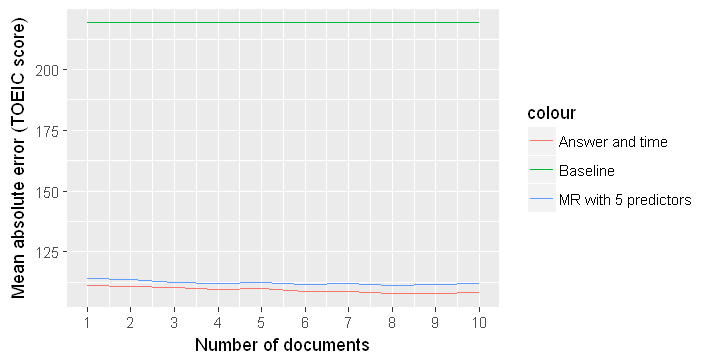

In [30]:
df1 <- data.frame(x = 1:10, y = apply(cv_error_late_1, 2, mean))
df2 <- data.frame(x = 1:10, y = apply(cv_error_late_2, 2, mean))
df3 <- data.frame(x = 1:10, y = mean(mae_baseline))
options(repr.plot.width= 6, repr.plot.height= 3)
ggplot()+
  geom_line(data = df1, aes(x = x, y = y, color = 'MR with 5 predictors'))+
  geom_line(data = df2, aes(x = x, y = y, color = 'Answer and time'))+
  geom_line(data = df3, aes(x = x, y = y, color = 'Baseline'))+
  xlab('Number of documents')+
  scale_x_continuous(breaks = seq(1, 10, 1))+
  ylab('Mean absolute error (TOEIC score)')
options(default_opt)

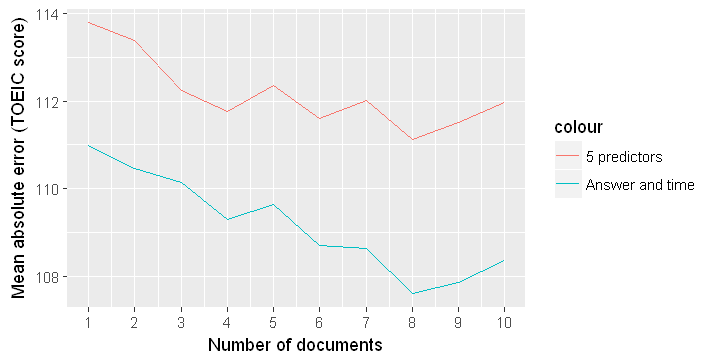

In [31]:
options(repr.plot.width= 6, repr.plot.height= 3)
ggplot()+
  geom_line(data = df1, aes(x = x, y = y, color = '5 predictors'))+
  geom_line(data = df2, aes(x = x, y = y, color = 'Answer and time'))+
  #geom_line(data = df3, aes(x = x, y = y, color = 'Baseline'))+
  xlab('Number of documents')+
  scale_x_continuous(breaks = seq(1, 10, 1))+
  ylab('Mean absolute error (TOEIC score)')
options(default_opt)

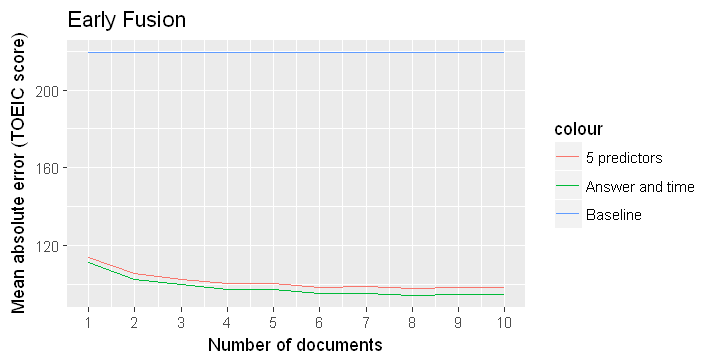

In [32]:
df1_early <- data.frame(x = 1:10, y = apply(cv_error_early_1, 2, mean))
df2_early <- data.frame(x = 1:10, y = apply(cv_error_early_2, 2, mean))

options(repr.plot.width= 6, repr.plot.height= 3)
ggplot()+
  geom_line(data = df1_early, aes(x = x, y = y, color = '5 predictors'))+
  geom_line(data = df2_early, aes(x = x, y = y, color = 'Answer and time'))+
  geom_line(data = df3, aes(x = x, y = y, color = 'Baseline'))+
  xlab('Number of documents')+
  scale_x_continuous(breaks = seq(1, 10, 1))+
  ylab('Mean absolute error (TOEIC score)')+
  ggtitle('Early Fusion')
options(default_opt)

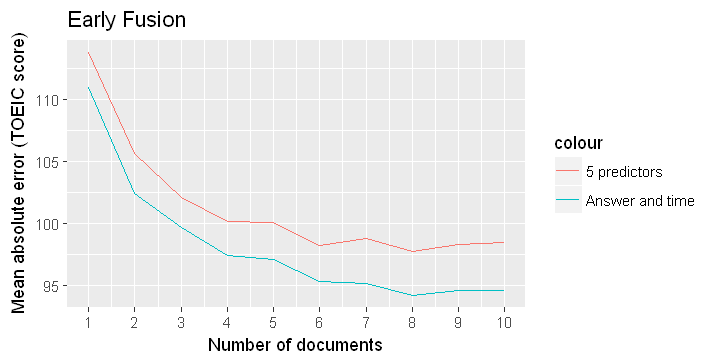

In [34]:
options(repr.plot.width= 6, repr.plot.height= 3)
ggplot()+
  geom_line(data = df1_early, aes(x = x, y = y, color = '5 predictors'))+
  geom_line(data = df2_early, aes(x = x, y = y, color = 'Answer and time'))+
  #geom_line(data = df3, aes(x = x, y = y, color = 'Baseline'))+
  xlab('Number of documents')+
  scale_x_continuous(breaks = seq(1, 10, 1))+
  ylab('Mean absolute error (TOEIC score)')+
  ggtitle('Early Fusion')
options(default_opt)

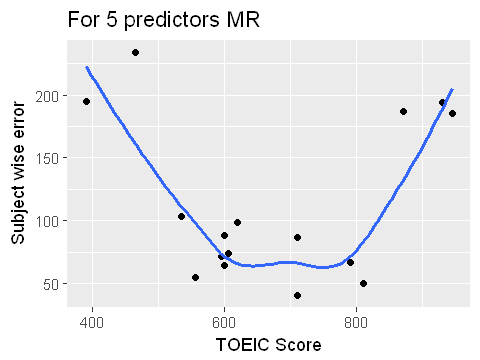

In [35]:
# plotting subject wise error with TOEIC score for 5 predictors MR

df_subject_error <- unique(df_toeic[, c('subject', 'TOEIC')])
df_subject_error$error <- rowMeans(cv_error_late_1)
options(repr.plot.width= 4, repr.plot.height= 3)
ggplot(df_subject_error, aes(x = TOEIC, y = error)) +
  geom_point()+
  ylab('Subject wise error')+
  xlab('TOEIC Score')+
  ggtitle('For 5 predictors MR')+
  geom_smooth(method = 'loess', se = FALSE)
options(default_opt)

In [36]:
# performing lasso regression with 5 predictors

response <- 'TOEIC'
#predictors <- col_names[-c(2, 3, 5)]
#predictors <- c('Export_End_Trial_Time_ms', 'Fixation_Duration_Total_ms', 
#                'Saccade_Duration_Total_ms', 'Saccade_Count', 
#                'Fixation_Count', 'Saccade_Amplitude_Total_deg', 
#                'Saccade_Velocity_Total_deg_s', 'Scanpath_Length_px', 'answer')

predictors <- c('Export_End_Trial_Time_ms', 'answer', 'Saccade_Duration_Total_ms', 'Saccade_Amplitude_Total_deg', 
                'Saccade_Count')
reg_formula <- as.formula(paste(response, paste(predictors, collapse = '+'),
                                sep = '~'))

lambda_grid <- 10^seq(3, -3, length.out = 100)
cv_error_lasso_late <- array(NA, c(length(subjects), length(lambda_grid), length(subjects)),
                            dimnames = list(subjects, 1:length(lambda_grid), subjects))
test_error_lasso_late <- matrix(NA, nrow = length(subjects), ncol = 10,
                                dimnames = list(subjects, 1:10))

for(i in 1:length(subjects)){
  
  df_test <- df_toeic[df_toeic$subject == subjects[i], ]
  df_train <- df_toeic[!(df_toeic$subject == subjects[i]), ]
  
  tr_feature_mean <- colMeans(df_train[, predictors])
  tr_feature_sd <- apply(df_train[, predictors], 2, sd)
  
  for(j in subjects[-i]){
    df_cv_ls <- df_train[df_train$subject == j,]
    df_train_ls <- df_train[!(df_train$subject == j), ]
    
    train_ls_mean <- colMeans(df_train_ls[, predictors])
    train_ls_sd <- apply(df_train_ls[, predictors], 2, sd)
    
    # normalizing cv and corresponding train data
    for(f in predictors){
      df_train_ls[, f] <- (df_train_ls[, f] - train_ls_mean[f]) / train_ls_sd[f]
      df_cv_ls[, f] <- (df_cv_ls[, f] - train_ls_mean[f]) / train_ls_sd[f]
    }
  
    # apply(df_train_ls[, predictors], 2, sd)
    # colMeans(df_train_ls[,predictors])
    
    x_cv_ls <- model.matrix(reg_formula, data = df_cv_ls)
    y_cv_ls <- df_cv_ls$TOEIC
    
    x_train_ls <- model.matrix(reg_formula, data = df_train_ls)[, -1]
    y_train_ls <- df_train_ls$TOEIC
    
    model_lasso <- glmnet(x_train_ls, y_train_ls, alpha = 1, lambda = lambda_grid,
                          standardize = F)
    pred <- as.matrix(x_cv_ls %*% coef(model_lasso))
    res <- matrix(rep(y_cv_ls, length(lambda_grid)), nrow = nrow(df_cv_ls), 
                  ncol = length(lambda_grid), byrow = F)
    cv_error_lasso_late[j, , i] <- colMeans(abs(pred - res))
    
  }
  
  cv_error_lambda <- colMeans(cv_error_lasso_late[, , i], na.rm = TRUE)
  lambda_idx <- which(cv_error_lambda == min(cv_error_lambda))
  
  # normalizing the train and test data
  for(f in predictors){
    df_train[, f] <- (df_train[, f] - tr_feature_mean[f]) / tr_feature_sd[f]
    df_test[, f] <- (df_test[, f] - tr_feature_mean[f]) / tr_feature_sd[f]
  }
  
  x_train_ls <- model.matrix(reg_formula, df_train)[, -1]
  y_train_ls <- df_train$TOEIC
  x_test_ls <- model.matrix(reg_formula, df_test)
  y_test_ls <- df_test$TOEIC
  
  reg_model_lasso <- glmnet(x_train_ls, y_train_ls, alpha = 1, lambda = lambda_grid,
                            standardize = F)
  coef_lasso <- coef(reg_model_lasso)[, lambda_idx]
  
  # testing
  for(doc in 1:10){
    doc_sample_comb <- combn(length(docs), m = doc)
    n_comb <- min(100, ncol(doc_sample_comb))
    mae <- c()
    for(comb in 1:n_comb){
      idx <- df_test$Participant %in% docs[doc_sample_comb[, comb]]
      pred <- x_test_ls[idx, names(coef_lasso)] %*% coef_lasso
      err <- mean(abs(pred - df_test[df_test$Participant %in% docs[doc_sample_comb[, comb]], 'TOEIC']))
      mae <- c(mae, err)
    }
    test_error_lasso_late[i, doc] <- mean(mae, na.rm = T)
  }
}

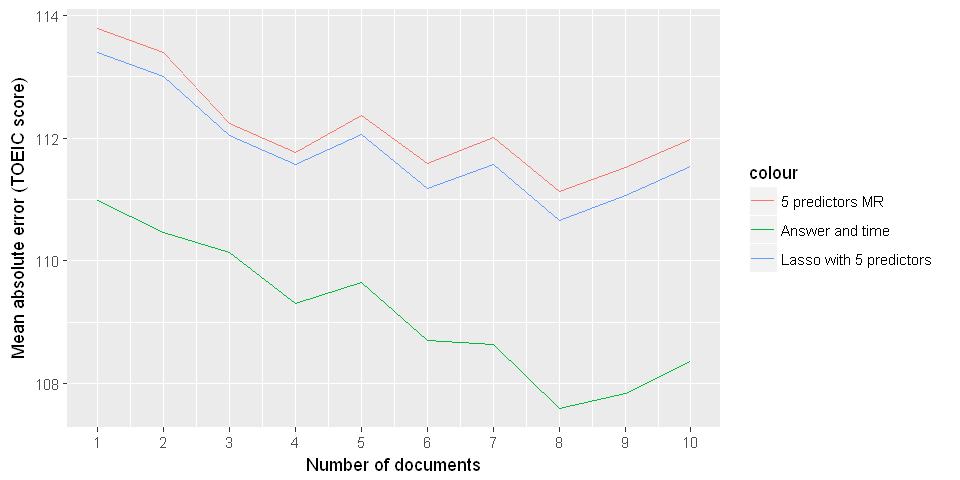

In [37]:
df_lasso <- data.frame(x = 1:10, y = colMeans(test_error_lasso_late))
options(repr.plot.width= 8, repr.plot.height= 4)
ggplot()+
  geom_line(data = df1, aes(x = x, y = y, color = '5 predictors MR'))+
  geom_line(data = df2, aes(x = x, y = y, color = 'Answer and time'))+
  #geom_line(data = df3, aes(x = x, y = y, color = 'Baseline'))+
  geom_line(data = df_lasso, aes(x = x, y = y, color = 'Lasso with 5 predictors'))+
  xlab('Number of documents')+
  scale_x_continuous(breaks = seq(1, 10, 1))+
  ylab('Mean absolute error (TOEIC score)')
options(default_opt)

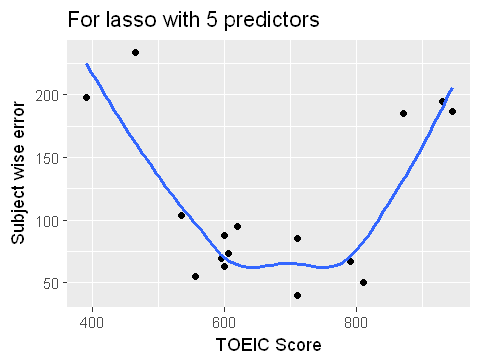

In [38]:
# plotting subject wise error with TOEIC score for lasso

df_subject_error <- unique(df_toeic[, c('subject', 'TOEIC')])
df_subject_error$error <- rowMeans(test_error_lasso_late)
options(repr.plot.width= 4, repr.plot.height= 3)
ggplot(df_subject_error, aes(x = TOEIC, y = error)) +
  geom_point()+
  ylab('Subject wise error')+
  xlab('TOEIC Score')+
  ggtitle('For lasso with 5 predictors')+
  geom_smooth(method = 'loess', se = FALSE)
options(default_opt)

In [39]:
# performing ridge regression on the 5 predictors

response <- 'TOEIC'
#predictors <- col_names[-c(2, 3, 5)]
#predictors <- c('Export_End_Trial_Time_ms', 'Fixation_Duration_Total_ms', 
#                'Saccade_Duration_Total_ms', 'Saccade_Count', 
#                'Fixation_Count', 'Saccade_Amplitude_Total_deg', 
#                'Saccade_Velocity_Total_deg_s', 'Scanpath_Length_px', 'answer')

predictors <- c('Export_End_Trial_Time_ms', 'answer', 'Saccade_Duration_Total_ms', 'Saccade_Amplitude_Total_deg', 
                  'Saccade_Count')

reg_formula <- as.formula(paste(response, paste(predictors, collapse = '+'),
                                sep = '~'))

lambda_grid <- 10^seq(3, -3, length.out = 100)
cv_error_ridge_late <- array(NA, c(length(subjects), length(lambda_grid), length(subjects)),
                             dimnames = list(subjects, 1:length(lambda_grid), subjects))
test_error_ridge_late <- matrix(NA, nrow = length(subjects), ncol = 10,
                                dimnames = list(subjects, 1:10))

for(i in 1:length(subjects)){
  
  df_test <- df_toeic[df_toeic$subject == subjects[i], ]
  df_train <- df_toeic[!(df_toeic$subject == subjects[i]), ]
  
  tr_feature_mean <- colMeans(df_train[, predictors])
  tr_feature_sd <- apply(df_train[, predictors], 2, sd)
  
  for(j in subjects[-i]){
    df_cv_rg <- df_train[df_train$subject == j,]
    df_train_rg <- df_train[!(df_train$subject == j), ]
    
    train_rg_mean <- colMeans(df_train_rg[, predictors])
    train_rg_sd <- apply(df_train_rg[, predictors], 2, sd)
    
    # normalizing cv and corresponding train data
    for(f in predictors){
      df_train_rg[, f] <- (df_train_rg[, f] - train_rg_mean[f]) / train_rg_sd[f]
      df_cv_rg[, f] <- (df_cv_rg[, f] - train_rg_mean[f]) / train_rg_sd[f]
    }
    
    # apply(df_train_ls[, predictors], 2, sd)
    # colMeans(df_train_ls[,predictors])
    
    x_cv_rg <- model.matrix(reg_formula, data = df_cv_rg)
    y_cv_rg <- df_cv_rg$TOEIC
    
    x_train_rg <- model.matrix(reg_formula, data = df_train_rg)[, -1]
    y_train_rg <- df_train_rg$TOEIC
    
    model_rg <- glmnet(x_train_rg, y_train_rg, alpha = 0, lambda = lambda_grid,
                       standardize = F)
    pred <- as.matrix(x_cv_rg %*% coef(model_rg))
    res <- matrix(rep(y_cv_rg, length(lambda_grid)), nrow = nrow(df_cv_rg), 
                  ncol = length(lambda_grid), byrow = F)
    cv_error_ridge_late[j, , i] <- colMeans(abs(pred - res))
    
  }
  
  cv_error_lambda <- colMeans(cv_error_ridge_late[, , i], na.rm = TRUE)
  lambda_idx <- which(cv_error_lambda == min(cv_error_lambda))
  
  # normalizing the train and test data
  for(f in predictors){
    df_train[, f] <- (df_train[, f] - tr_feature_mean[f]) / tr_feature_sd[f]
    df_test[, f] <- (df_test[, f] - tr_feature_mean[f]) / tr_feature_sd[f]
  }
  
  x_train_rg <- model.matrix(reg_formula, df_train)[, -1]
  y_train_rg <- df_train$TOEIC
  x_test_rg <- model.matrix(reg_formula, df_test)
  y_test_rg <- df_test$TOEIC
  
  reg_model_ridge <- glmnet(x_train_rg, y_train_rg, alpha = 0, lambda = lambda_grid,
                            standardize = F)
  coef_ridge <- coef(reg_model_ridge)[, lambda_idx]
  
  # testing
  for(doc in 1:10){
    doc_sample_comb <- combn(length(docs), m = doc)
    n_comb <- min(100, ncol(doc_sample_comb))
    mae <- c()
    for(comb in 1:n_comb){
      idx <- df_test$Participant %in% docs[doc_sample_comb[, comb]]
      pred <- x_test_rg[idx, names(coef_ridge)] %*% coef_ridge
      err <- mean(abs(pred - df_test[df_test$Participant %in% docs[doc_sample_comb[, comb]], 'TOEIC']))
      mae <- c(mae, err)
    }
    test_error_ridge_late[i, doc] <- mean(mae, na.rm = T)
  }
}

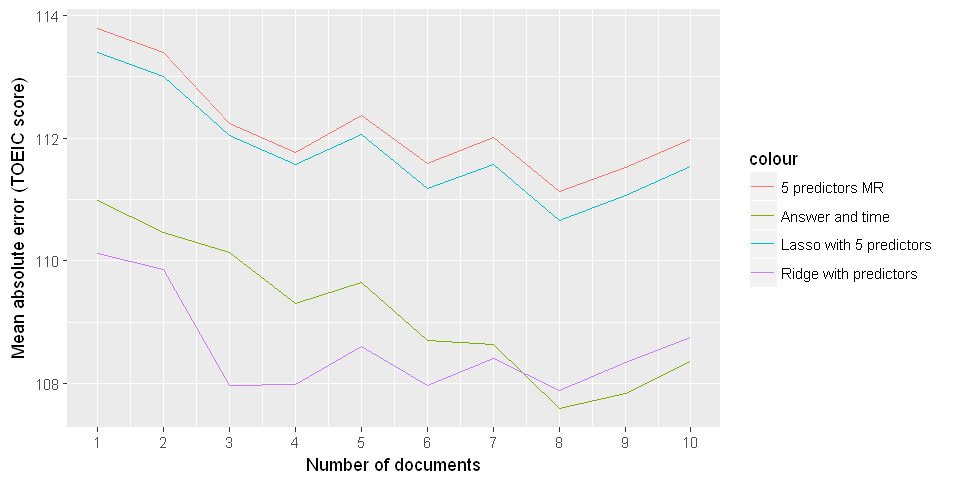

In [40]:
df_ridge <- data.frame(x = 1:10, y = colMeans(test_error_ridge_late))
options(repr.plot.width= 8, repr.plot.height= 4)
ggplot()+
  geom_line(data = df1, aes(x = x, y = y, color = '5 predictors MR'))+
  geom_line(data = df2, aes(x = x, y = y, color = 'Answer and time'))+
  #geom_line(data = df3, aes(x = x, y = y, color = 'Baseline'))+
  geom_line(data = df_lasso, aes(x = x, y = y, color = 'Lasso with 5 predictors'))+
  geom_line(data = df_ridge, aes(x = x, y = y, color = 'Ridge with predictors'))+
  xlab('Number of documents')+
   scale_x_continuous(breaks = seq(1, 10, 1))+
  ylab('Mean absolute error (TOEIC score)')
options(default_opt)

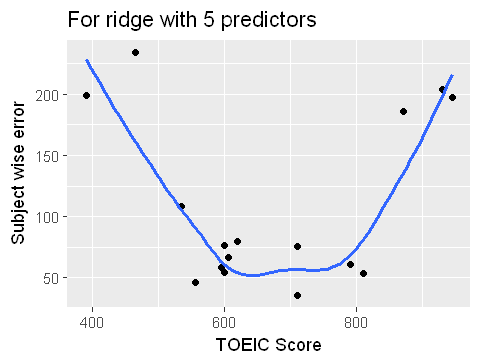

In [41]:
# plotting subject wise error with TOEIC score for ridge
df_subject_error <- unique(df_toeic[, c('subject', 'TOEIC')])
df_subject_error$error <- rowMeans(test_error_ridge_late)
options(repr.plot.width= 4, repr.plot.height= 3)
ggplot(df_subject_error, aes(x = TOEIC, y = error)) +
  geom_point()+
  ylab('Subject wise error')+
  xlab('TOEIC Score')+
  ggtitle('For ridge with 5 predictors')+
  geom_smooth(method = 'loess', se = FALSE)
options(default_opt)

In [19]:
# fitting a support vector regression model with the 5 vars
response <- 'TOEIC'

predictors <- c('Export_End_Trial_Time_ms', 'answer', 'Saccade_Duration_Total_ms', 'Saccade_Amplitude_Total_deg', 
                'Saccade_Count')
reg_formula <- as.formula(paste(response, paste(predictors, collapse = '+'),
                                sep = '~'))

param_ranges <- list(cost = 10^seq(1, 2, length.out = 10),
                    gamma = 2^seq(-2, -1, length.out = 10))
param_grid <- expand.grid(param_ranges)
param_grid$error <- NA
best_params <- list()
test_error_svm_late <- matrix(NA, nrow = length(subjects), ncol = 10, 
                              dimnames = list(subjects, 1:10))
for(i in 1:length(subjects)){
  #print(i)
  param_grid$error <- 0
  df_train <- df_toeic[!(df_toeic$subject == subjects[i]), ]
  df_test <- df_toeic[df_toeic$subject == subjects[i], ]
  
  train_feature_mean <- colMeans(df_train[, predictors])
  train_feature_sd <- apply(df_train[, predictors], 2, sd)
  
  for(j in subjects[-i]){
    df_train_svr <- df_train[!(df_train$subject == j), ]
    df_cv_svr <- df_train[df_train$subject == j, ]
    
    tr_mean <- colMeans(df_train_svr[, predictors])
    tr_sd <- apply(df_train_svr[, predictors], 2, sd)
    
    # normalizing the cv set and the corresponding training set
    for(f in predictors){
      df_train_svr[, f] <- (df_train_svr[, f] - tr_mean[f]) / tr_sd[f]
      df_cv_svr[, f] <- (df_cv_svr[, f] - tr_mean[f]) / tr_sd[f]
    }
    
    
    svm_tune <- tune(svm, reg_formula, data = df_train_svr,
                     validation.x = df_cv_svr, ranges = param_ranges,
                     kernel = 'radial', scale = F,
                     tunecontrol = tune.control(sampling = "fix", fix = 1))
  
    
    param_grid$error <- param_grid$error + svm_tune$performances[, 'error']
  }
  idx <- which(min(param_grid$error) == param_grid$error)
  best_gamma <- param_grid$gamma[idx]
  best_cost <- param_grid$cost[idx]
  #best_coef0 <- param_grid$coef0[idx]
  best_params[[i]] <- c('best_cost' = best_cost,
                        'best_gamma' = best_gamma)
                        #'best_coef0' = best_coef0)
  # normalizing train and test set
  for(f in predictors){
    df_train[, f] <- (df_train[, f] - train_feature_mean[f]) / train_feature_sd[f]
    df_test[, f] <- (df_test[, f] - train_feature_mean[f]) / train_feature_sd[f]
  }
  
  reg_svm <- svm(reg_formula, data = df_train, scale = FALSE, gamma = best_gamma,
                 kernel = 'radial', cost = best_cost)
  
  # testing
  for(doc in 1:10){
    doc_sample_comb <- combn(length(docs), m = doc)
    n_comb <- min(100, ncol(doc_sample_comb))
    mae <- c()
    for(comb in 1:n_comb){
      pred <- predict(reg_svm, df_test[df_test$Participant %in% docs[doc_sample_comb[, comb]], ])
      err <- mean(abs(pred - df_test[df_test$Participant %in% docs[doc_sample_comb[, comb]], 'TOEIC']))
      mae <- c(mae, err)
    }
    test_error_svm_late[i, doc] <- mean(mae, na.rm = T)
  }
}

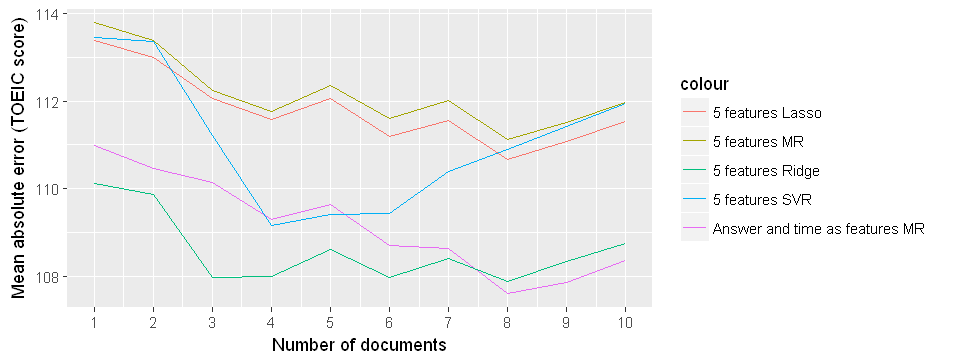

In [20]:
df_svr <- data.frame(x = 1:10, y = colMeans(test_error_svm_late))
options(repr.plot.width= 8, repr.plot.height= 3)
ggplot()+
  geom_line(data = df1, aes(x = x, y = y, color = '5 features MR'))+
  geom_line(data = df2, aes(x = x, y = y, color = 'Answer and time as features MR'))+
  #geom_line(data = df3, aes(x = x, y = y, color = 'Baseline'))+
  geom_line(data = df_lasso, aes(x = x, y = y, color = '5 features Lasso'))+
  geom_line(data = df_ridge, aes(x = x, y = y, color = '5 features Ridge'))+
  geom_line(data = df_svr, aes(x = x, y = y, color = '5 features SVR'))+
  xlab('Number of documents')+
  scale_x_continuous(breaks = seq(1, 10, 1))+
  ylab('Mean absolute error (TOEIC score)')
options(default_opt)

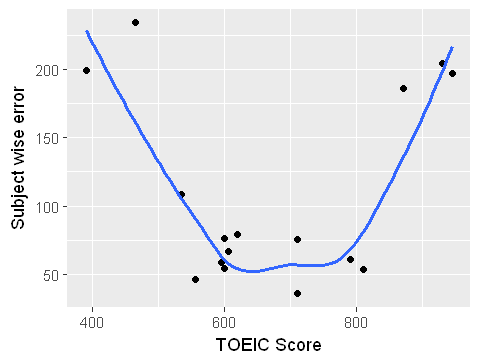

In [42]:
# plotting subject wise error with TOEIC score for ridge
df_subject_error <- unique(df_toeic[, c('subject', 'TOEIC')])
df_subject_error$error <- rowMeans(test_error_ridge_late)
options(repr.plot.width= 4, repr.plot.height= 3)
ggplot(df_subject_error, aes(x = TOEIC, y = error)) +
  geom_point()+
  ylab('Subject wise error')+
  xlab('TOEIC Score')+
  geom_smooth(method = 'loess', se = FALSE)
options(default_opt)